# 1. Overview

The notebook details a process to select ASML suppliers by analyzing historical stock data for companies like: Carl Zeiss Meditec, Lam Research Corporation, and Tokyo Electron Limited. It involves retrieving stock data, plotting trends, checking for seasonality, and using Prophet models to forecast weekly closing prices. The forecasting models for each supplier were optimized through fine-tuning, and key metrics like MAPE and RMSE were calculated to assess accuracy. The final models were saved, along with the weekly supplier data, for future reference and further analysis.

# 2. Data Understanding

## 2.1 Data Description

## 2.2 Import necessary libraries

In [1]:
# pip install optuna

In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings
import logging
import joblib
import logging
import sys
import os
import warnings
import pickle

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sktime.utils.plotting import plot_series
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from itertools import product

logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# Suppress the SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
# Disable all logs from cmdstanpy by setting the logger to the CRITICAL Level
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)

# Suppress specific warnings to avoid red messages in the output
warnings.filterwarnings("ignore", category=UserWarning)  # Ignore user-related warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore future-related warnings
logging.getLogger('prophet').setLevel(logging.ERROR)

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.3 Define Global Variables

In [3]:
# Define the company tickers and names
company_tickers = {
    'CZMWY': 'Carl_Zeiss_Meditec',
    'LRCX': 'Lam_Research_Corporation',
    'TOELY': 'Tokyo_Electron_Limited',
#     'AMAT':'Applied_Materials',
#     'MKSI':'MKS_Instruments'
#     'TSM': 'Taiwan_Semiconductor_Manufacturing_Company',
#     '005930.KS': 'Samsung_Electronics',
#     'INTC': 'Intel_Corporation'
}

output_start_data_and_test_weeks_path = '../data/start_data_and_test_weeks.pkl'
output_data = '../data/weekly_data_suppliers.csv'
date_to_consider = '2024-11-28'
date_to_consider = datetime.strptime(date_to_consider, '%Y-%m-%d').date()

## 2.4 Functions

In [4]:
def get_historical_data(ticker_symbol:str, start_date:str, end_date:str)->pd.DataFrame:
    """
    Fetches historical stock data for a given company between specified dates. 
    Returns a DataFrame containing the historical data.

    Input:
    - ticker_symbol: The stock ticker of the company (e.g., 'ASML').
    - start_date: The start date for the historical data (e.g., '2000-01-01').
    - end_date: The end date for the historical data (e.g., '2024-10-05').

    Output:
    - A pandas DataFrame containing the historical stock data for the specified period.
    """
    # Define the ticker symbol
    stock_data = yf.Ticker(ticker_symbol)

    # Download historical data between the start and end dates
    historical_data = stock_data.history(start=start_date, end=end_date)

    # Reset the index to convert 'Date' from an index to a regular column
    historical_data.reset_index(inplace=True)

    # Return the resulting DataFrame
    return historical_data

In [5]:
def plot_closing_prices(data:pd.DataFrame, close_column:str, company_name:str):
    """
    Plots the historical closing prices of a company's stock over time.

    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.

    Output:
    - A line plot of the company's historical closing prices.
    """
    
    # Convert the 'Date' and 'Close' columns to numpy arrays
    dates = np.array(data.index)
    close_prices = np.array(data[close_column])

    # Create the plot for the 'Close' (closing price) column using matplotlib
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(dates, close_prices, label='Closing Price', color='blue')

    # Add title and axis labels
    plt.title(f'Historical Closing Prices of {company_name} between {dates[0]} and {dates[-1]}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')

    # Rotate X-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the legend
    plt.legend()

    # Adjust layout to prevent overlap of elements
    plt.tight_layout()

    # Display the plot
    plt.show()


In [6]:
def plot_stock_with_multiple_boxplots(data: pd.DataFrame, close_column: str, company_name: str):
    """
    Plots the stock's closing price distribution for weekly, monthly, and quarterly with
    multiple boxplots for each period.
    
    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.
    
    Output:
    - Boxplots for each period (7 for weekly, 12 for monthly, and 4 for quarterly).
    """

    # Ensure 'Date' column is in datetime format
    data['Date'] = pd.to_datetime(data.index)

    # Extract additional time period information
    data['Weekday'] = data['Date'].dt.weekday  # Weekday (0=Monday, 6=Sunday)
    data['Month'] = data['Date'].dt.month      # Month (1=January, 12=December)
    data['Quarter'] = data['Date'].dt.quarter  # Quarter (1 to 4)

    # Plot Weekly Data (7 boxplots for each day of the week)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Weekday', grid=True)
    plt.title(f'{company_name} - Weekly Closing Prices (by Weekday)')
    plt.suptitle('')
    plt.xlabel('Weekday (0=Monday, 6=Sunday)')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Monthly Data (12 boxplots for each month)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Month', grid=True)
    plt.title(f'{company_name} - Monthly Closing Prices (by Month)')
    plt.suptitle('')
    plt.xlabel('Month')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Quarterly Data (4 boxplots for each quarter)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Quarter', grid=True)
    plt.title(f'{company_name} - Quarterly Closing Prices (by Quarter)')
    plt.suptitle('')
    plt.xlabel('Quarter')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    return data

In [7]:
def get_last_friday(date_to_consider):
    """
    Input: No arguments; the function uses the current date as the starting point.
    Output: Returns `end_date` as a string formatted as `YYYY-MM-DD`, representing the last Friday's date.
    Logic: Calculate the number of days back to the last Friday.    
    
    """
    # Calculate the number of days back to the last Friday
    days_back = (date_to_consider.weekday() - 4) % 7
    last_friday = date_to_consider - timedelta(days=days_back)
    end_date = last_friday.strftime("%Y-%m-%d")
    return end_date


end_date = get_last_friday(date_to_consider)

## 2.5 Code

### 2.5.1 Looking at the dataset

We are going to load the start_data and test_weeks from notebook 01_data_understanding

In [8]:
# Load the variables using pickle
with open(output_start_data_and_test_weeks_path, 'rb') as f:
    variables = pickle.load(f)

# Extract the variables
start_date = variables['start_date']
test_weeks = variables['test_weeks']

We are going to load the data using the function get_historical_data

In [9]:
# Create an empty DataFrame for the merged data
merged_data = pd.DataFrame()

# Load historical data for each company and merge
for ticker, company_name in company_tickers.items():
    print(f"Loading data for {company_name}...")

    # Call the function get_historical_data for each ticker
    historical_data = get_historical_data(ticker, start_date, end_date)

    # Convert 'Date' column to datetime format and keep only the date (without time)
    historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date

    # Rename 'Close' column to include the company name
    historical_data.rename(columns={'Close': f'Close_{company_name.replace(' ','_')}'}, inplace=True)

    # If merged_data is empty, initialize it with the first company's data
    if merged_data.empty:
        merged_data = historical_data[['Date', f'Close_{company_name.replace(' ','_')}']]
    else:
        # Merge with the existing DataFrame on 'Date'
        merged_data = merged_data.merge(historical_data[['Date', f'Close_{company_name.replace(' ','_')}']], on='Date', how='outer')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)

# Display the merged data
merged_data.head()

Loading data for Carl_Zeiss_Meditec...
Loading data for Lam_Research_Corporation...
Loading data for Tokyo_Electron_Limited...


,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited
Date,,,
2018-01-02,59.144318,10.470731,30.773333
2018-01-03,59.808327,10.648857,31.266666
2018-01-04,59.808327,10.697539,32.273335
2018-01-05,59.808327,10.864599,32.513332
2018-01-08,61.117374,10.946471,32.746666


Now let's plot the stock data

****CARL_ZEISS_MEDITEC****



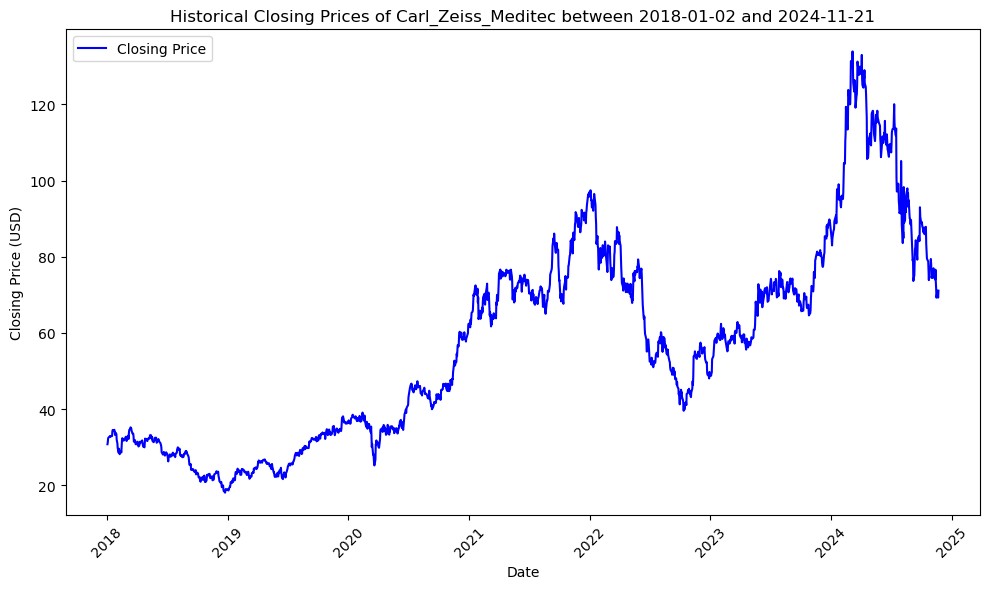


****LAM_RESEARCH_CORPORATION****



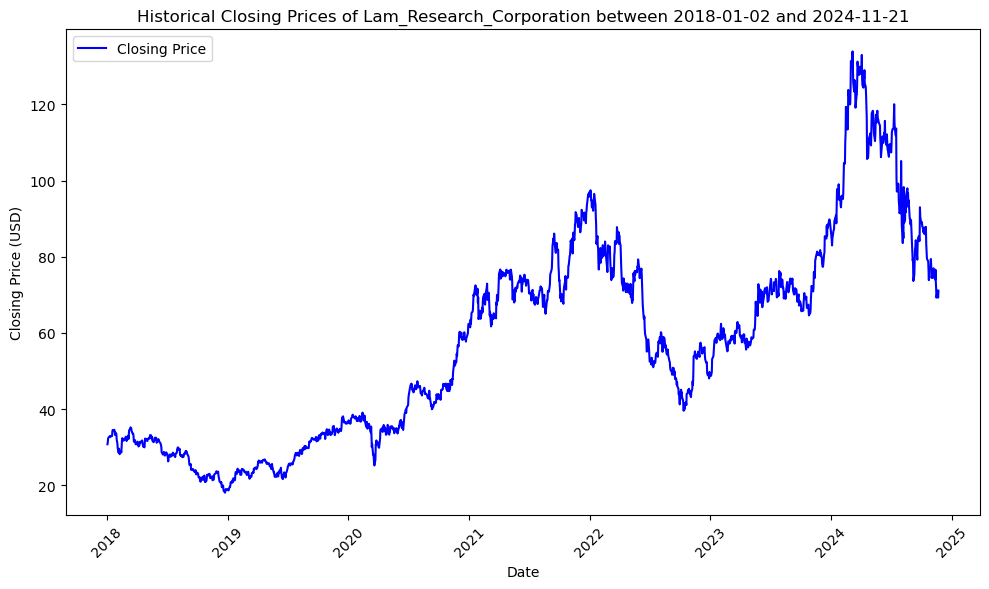


****TOKYO_ELECTRON_LIMITED****



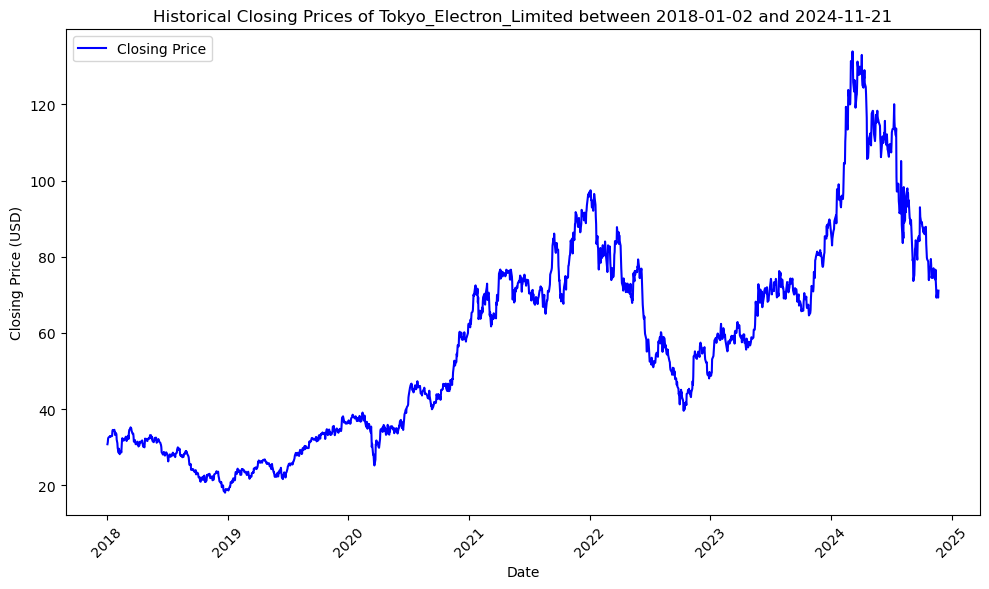

In [10]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_closing_prices(merged_data,f'Close_{company_name.replace(' ','_')}',company)
    print()

### 2.5.2 Checking for duplicate values

In [11]:
merged_data.duplicated().sum()

0

There is one duplicate value. We are going to eliminate it.

In [12]:
merged_data = merged_data[~merged_data.duplicated()]

### 2.5.3 Checking for missing dates

In [13]:
(merged_data.isna().sum()/len(merged_data))*100

Close_Carl_Zeiss_Meditec          0.0
Close_Lam_Research_Corporation    0.0
Close_Tokyo_Electron_Limited      0.0
dtype: float64

As we can see there are null values. However, since we are going to group data weekly, we will try to see if it can be solved in the following steps.

### 2.5.4 Looking at seasonality

****CARL_ZEISS_MEDITEC****



<Figure size 1200x800 with 0 Axes>

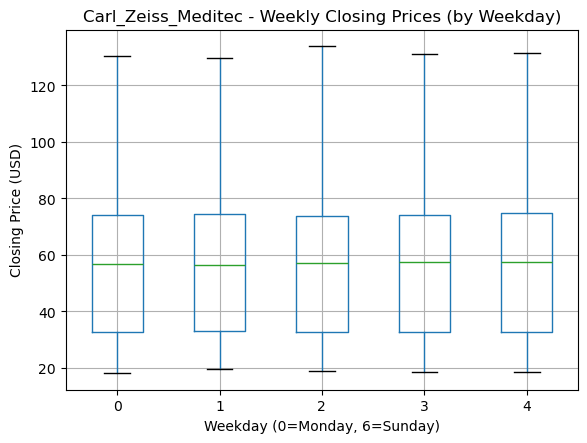

<Figure size 1200x800 with 0 Axes>

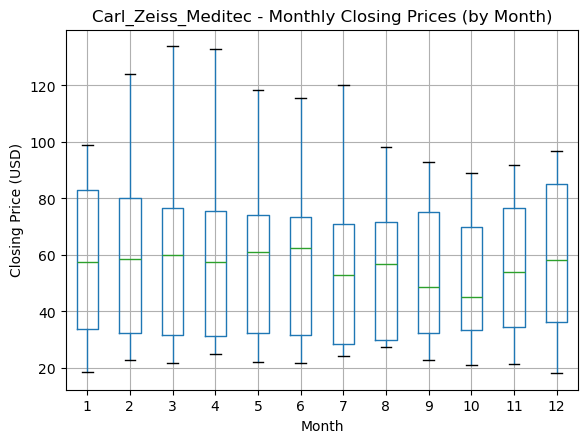

<Figure size 1200x800 with 0 Axes>

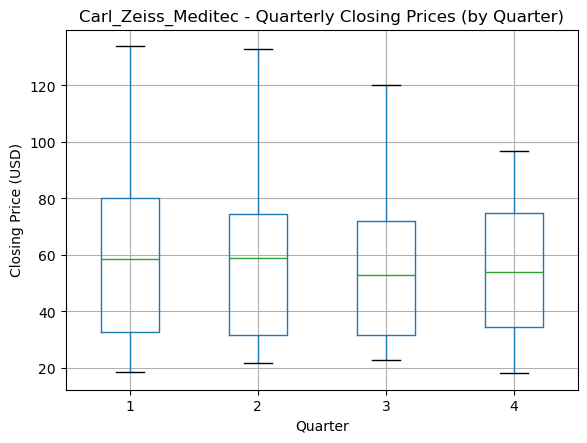


****LAM_RESEARCH_CORPORATION****



<Figure size 1200x800 with 0 Axes>

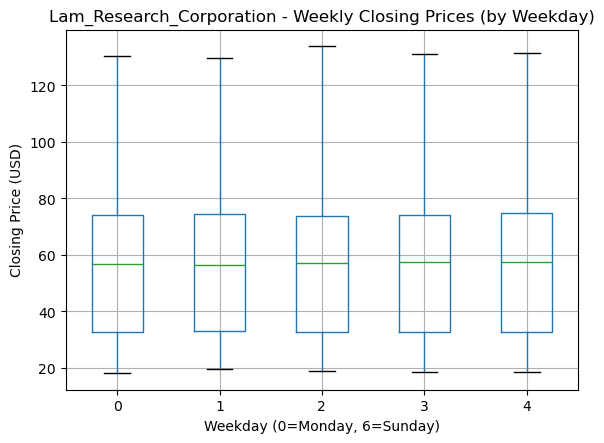

<Figure size 1200x800 with 0 Axes>

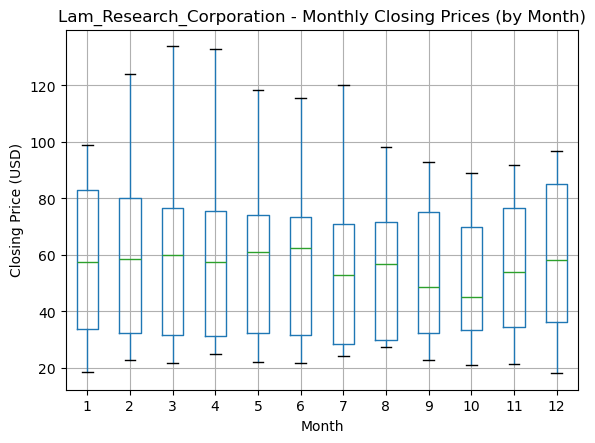

<Figure size 1200x800 with 0 Axes>

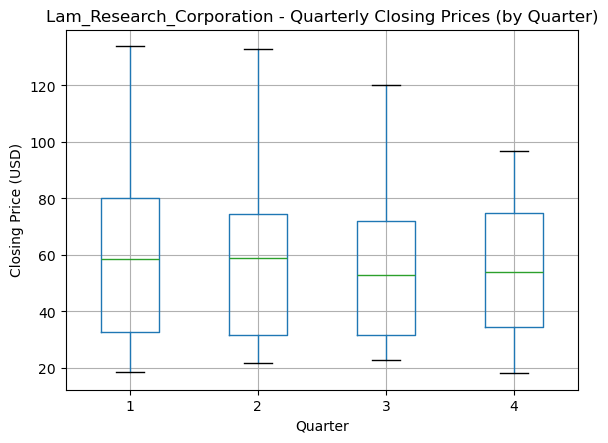


****TOKYO_ELECTRON_LIMITED****



<Figure size 1200x800 with 0 Axes>

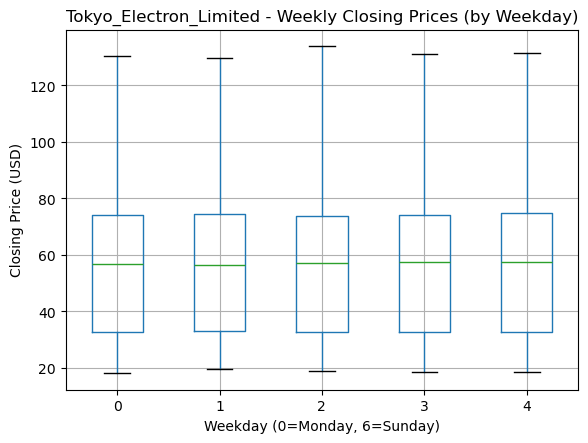

<Figure size 1200x800 with 0 Axes>

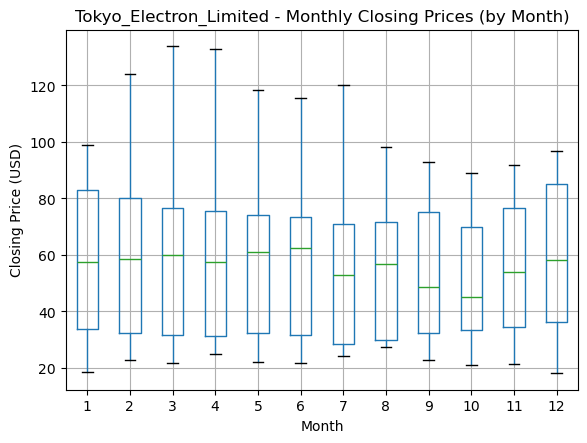

<Figure size 1200x800 with 0 Axes>

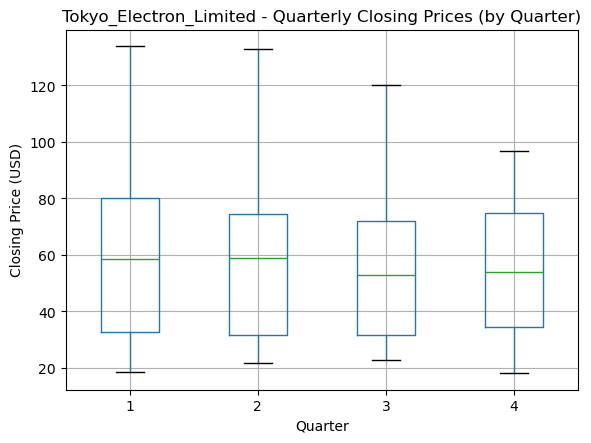

In [14]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_stock_with_multiple_boxplots(merged_data,f'Close_{company_name.replace(' ','_')}',company)
    print()

With the results above, we cannot determine if there is any clear seasonality for any of the three suppliers. 

### 2.5.5 Choosing the time series of our dataset

Let's chose just the weekly data for the suppliers. To be consistent with the logic with which we viewed ASML's stock data

In [15]:
# Convert the index to a datetime index if it's not already
merged_data.index = pd.to_datetime(merged_data.index)

# Resample the data to weekly frequency and calculate the median
weekly_data_suppliers = merged_data.resample('W').median()

# Display the weekly data
weekly_data_suppliers.head()

,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,Date,Weekday,Month,Quarter
Date,,,,,,,
2018-01-07,59.808327,10.673198,31.770000,2018-01-03 12:00:00,2.5,1.0,1.0
2018-01-14,60.946629,10.602388,32.766666,2018-01-10 00:00:00,2.0,1.0,1.0
2018-01-21,60.851768,11.355000,34.386667,2018-01-17 12:00:00,2.5,1.0,1.0
2018-01-28,61.373493,11.572125,34.026669,2018-01-24 00:00:00,2.0,1.0,1.0
2018-02-04,61.335556,10.570302,31.420000,2018-01-31 00:00:00,2.0,1.0,1.0


Let's check that the null values have disappeared with the weekly grouping of the stocks for each company

In [16]:
weekly_data_suppliers[weekly_data_suppliers['Close_Carl_Zeiss_Meditec'].isna()]

,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,Date,Weekday,Month,Quarter
Date,,,,,,,


As is observable, the null values have disappeared.

In [17]:
# Export the weekly_data_suppliers to a CSV file
weekly_data_suppliers.to_csv(output_data, index=True, sep=';')

### 2.5.6 Prophet model for each supplier

#### 2.5.6.1 Train-test split

In [18]:
# Drop unnecessary columns from the dataframe
weekly_data_suppliers = weekly_data_suppliers.drop(columns=['Date', 'Weekday', 'Month', 'Quarter'], axis=1)

In [19]:
# Create dictionaries to store train and test dataframes for each company
train_dataframes = {}
test_dataframes = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Filter only the columns corresponding to the current company
    company_data = weekly_data_suppliers[[f'Close_{company}']]
    
    # Rename the column to 'Close'
    company_data.columns = ['Close']
    
    # Create train and test dataframes
    train_dataframes[company] = company_data[:-test_weeks]
    test_dataframes[company] = company_data[-test_weeks:]
    
    # Set 'Date' as the index of the dataframe
    train_dataframes[company].index.name = 'Date'
    test_dataframes[company].index.name = 'Date'

# Display the train dataframe for 'Carl Zeiss Meditec' as an example
train_dataframes['Carl_Zeiss_Meditec']

,Close
Date,
2018-01-07,59.808327
2018-01-14,60.946629
2018-01-21,60.851768
2018-01-28,61.373493
2018-02-04,61.335556
...,...
2024-08-04,68.070000
2024-08-11,68.430000
2024-08-18,68.449997


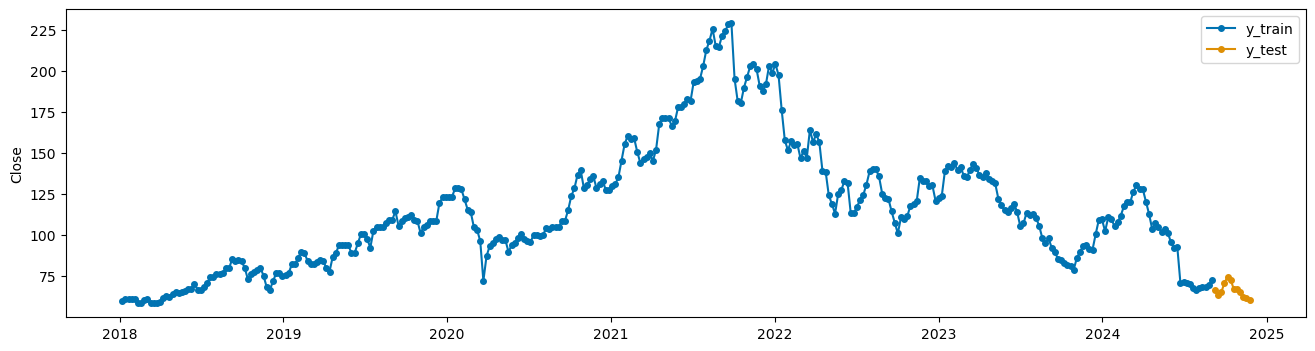

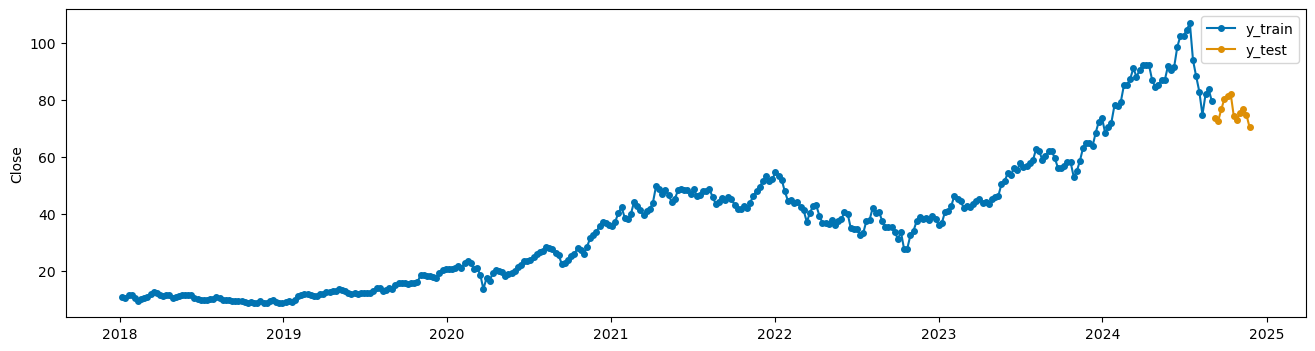

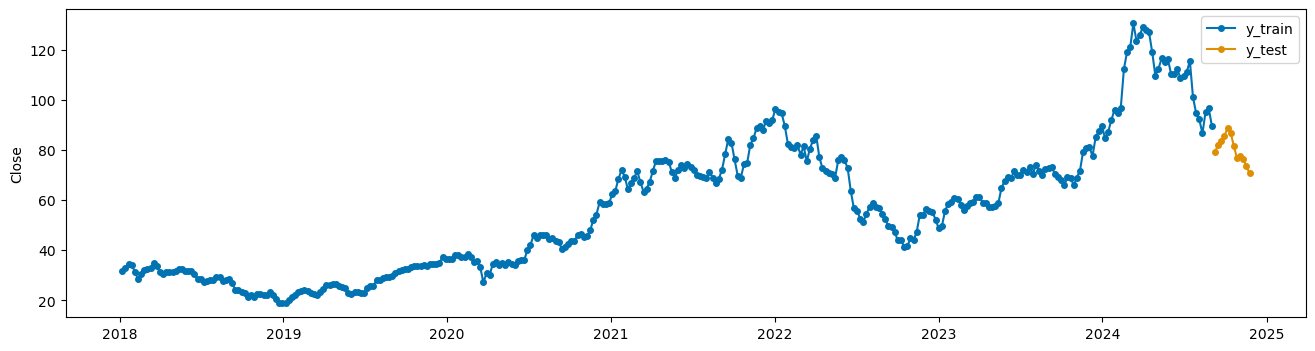

In [20]:
# Iterate over each company to plot the series
for company in company_tickers.values():
    # Extract the train and test data for the current company
    train_data = train_dataframes[company]
    test_data = test_dataframes[company]
    
    # Plot the series for the current company
    plot_series(train_data, test_data, labels=["y_train", "y_test"])

#### 2.5.6.2 Prophet models

Forecasting for Carl_Zeiss_Meditec
MAPE: 12.03
RMSE: 9.00


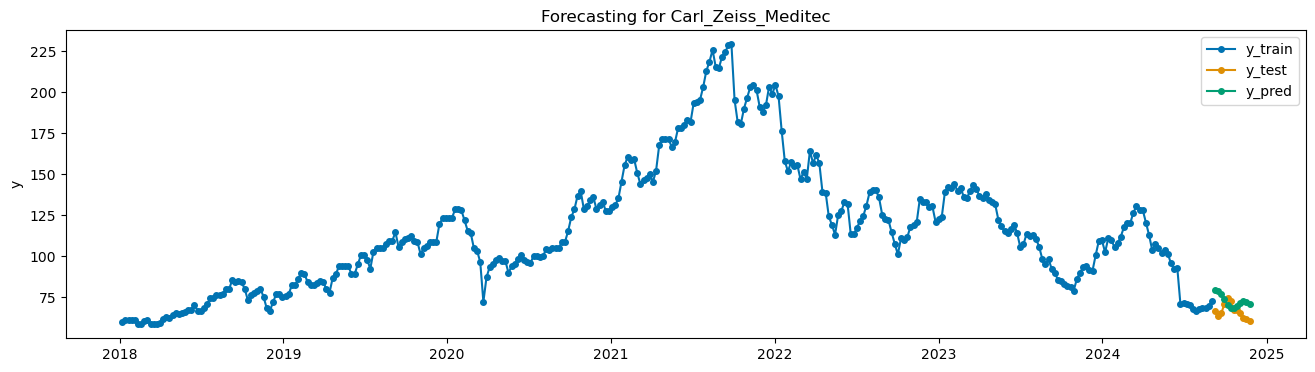

Forecasting for Lam_Research_Corporation
MAPE: 30.45
RMSE: 23.51


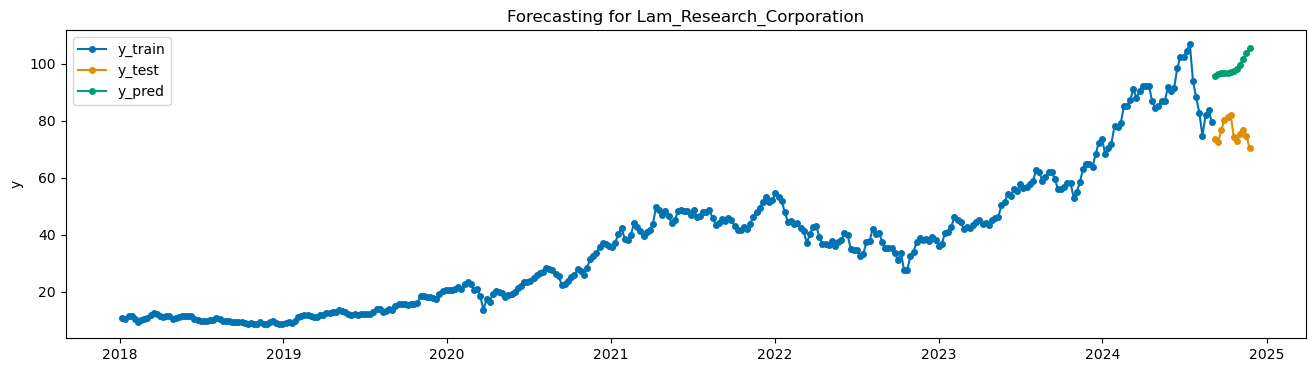

Forecasting for Tokyo_Electron_Limited
MAPE: 47.21
RMSE: 38.15


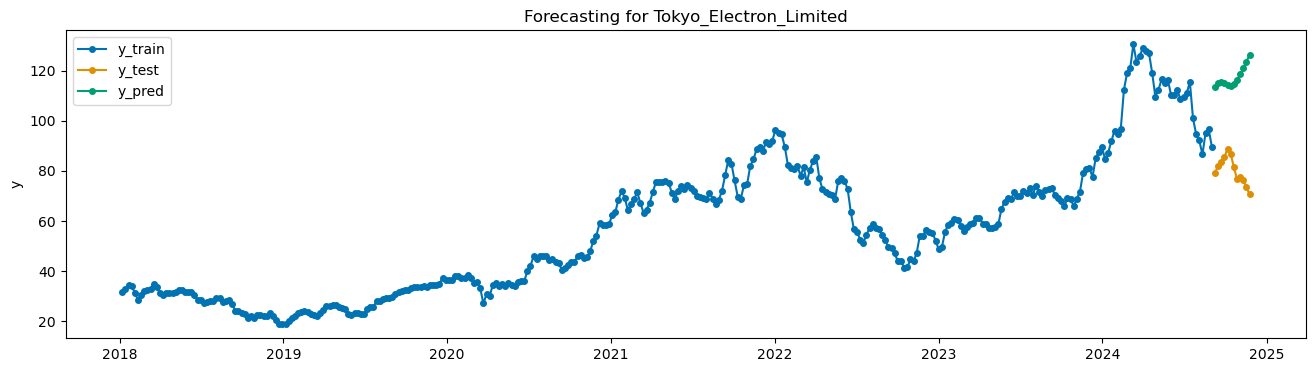

In [21]:
# Dictionary to store each Prophet model by company
prophet_models = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    
    # Prepare the data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure DatetimeIndex
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    # Initialize and fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(train_data_prophet)

    # Define the forecast horizon (e.g., 12 periods into the future)
    future = prophet_model.make_future_dataframe(periods=test_weeks, freq='W')

    # Generate the predictions
    forecast = prophet_model.predict(future)

    # Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
    forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    # Ensure 'ds' is the index of train_data_prophet 
    train_data_prophet = train_data_prophet.set_index('ds')

    # Calculate MAPE and RMSE errors
    actuals = test_dataframes[company]['Close']  # Actual values from test data
    predictions = forecast['Close']              # Predicted values from forecast

    # Ensure the indices of actuals and predictions align
    common_index = actuals.index.intersection(predictions.index)
    actuals = actuals.loc[common_index]
    predictions = predictions.loc[common_index]

    mape = mean_absolute_percentage_error(actuals, predictions)*100
    rmse = root_mean_squared_error(actuals, predictions)

    # Display errors
    print(f'Forecasting for {company}')
    print(f'MAPE: {mape:.2f}')
    print(f'RMSE: {rmse:.2f}')
    
    # Plot the forecast results
    plot_series(
        train_data_prophet[-500:],  # Only pass the 'Close' column for training data
        test_dataframes[company],   # Only pass the 'Close' column for test data
        forecast,                   # Only pass the 'Close' column for forecast
        labels=["y_train", "y_test", "y_pred"]
    )
    
    plt.title(f'Forecasting for {company}')  # Add title for better clarity
    plt.show()  # Show the plot before moving to the next company

#### 2.5.6.3 Fine-tunning the prophet models

We will first run a code using a gridsearch to gain an understanding of the approximate locations of the global minimal for each company.
(Expected execution time 30 minutes)

Optimizing for Carl_Zeiss_Meditec...

Forecasting for Carl_Zeiss_Meditec:
Best parameters: {'changepoint_prior_scale': 0.201, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.01, 'weekly_seasonality': False, 'yearly_seasonality': True}
MAPE: 8.73
RMSE: 6.71


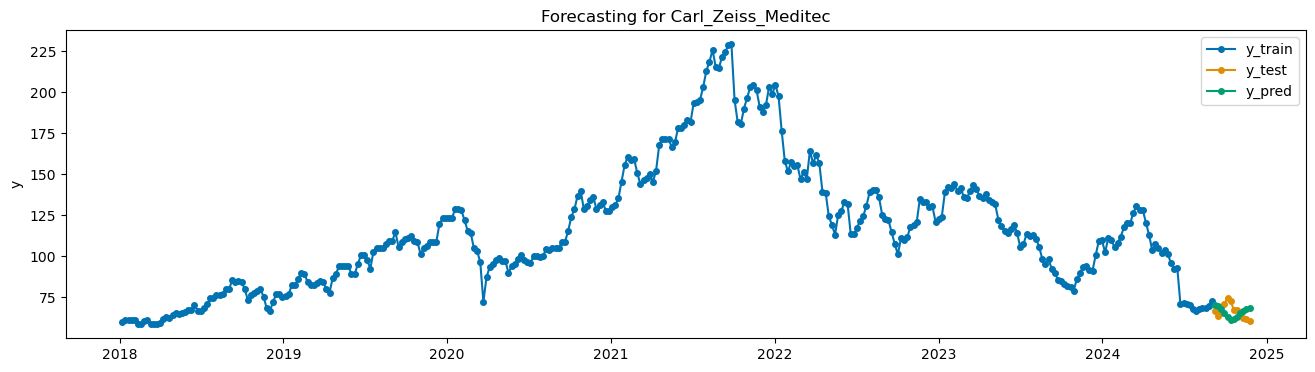

Optimizing for Lam_Research_Corporation...

Forecasting for Lam_Research_Corporation:
Best parameters: {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.01, 'weekly_seasonality': False, 'yearly_seasonality': False}
MAPE: 3.94
RMSE: 4.27


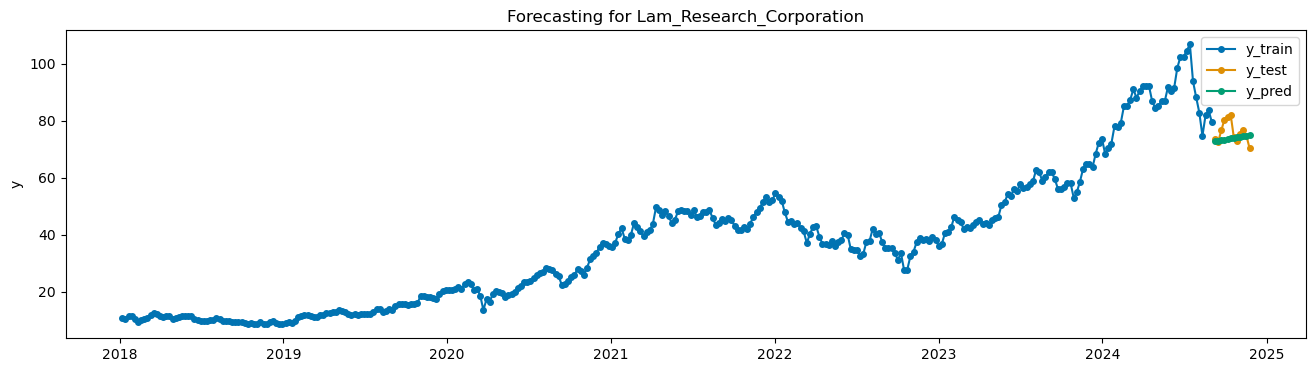

Optimizing for Tokyo_Electron_Limited...

Forecasting for Tokyo_Electron_Limited:
Best parameters: {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False, 'yearly_seasonality': False}
MAPE: 6.90
RMSE: 6.58


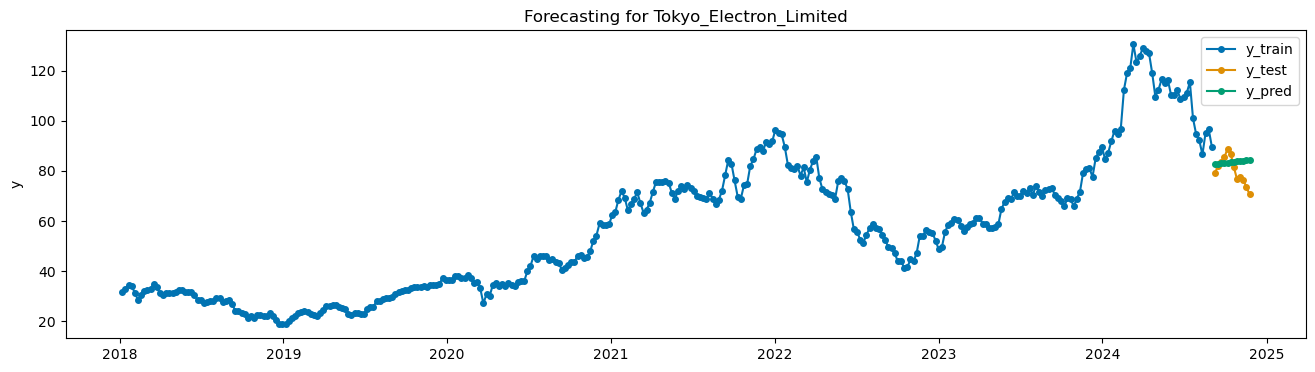

In [22]:
# Dictionary to store the best parameters, MAPE, and RMSE for each company
best_params_per_company = {}
final_mape_per_company = {}
final_rmse_per_company = {}
company_params = {}

# Define parameter grid
param_grid = {
    "changepoint_prior_scale": [round(x, 3) for x in np.arange(0.001, 1.001, 0.1)],
    "seasonality_prior_scale": [round(x, 2) for x in np.arange(0.01, 10.1, 1)],
    "seasonality_mode": ['multiplicative'],
    "weekly_seasonality": [True, False],
    "yearly_seasonality": [True, False],
    "daily_seasonality": [True, False]
}

# Create a parameter grid generator
grid = ParameterGrid(param_grid)

# Loop through each company in company_tickers
for ticker, company in company_tickers.items():
    print(f"Optimizing for {company}...")

    # Prepare training and test data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    test_data = test_dataframes[company][['Close']].copy()
    test_data.index = pd.to_datetime(test_data.index)

    # Initialize variables to track the best parameters
    best_mape = float('inf')
    best_rmse = float('inf')
    best_params = None
    best_forecast = None

    # Perform grid search using ParameterGrid
    for params in grid:
        try:
            # Train the Prophet model
            model = Prophet(
                changepoint_prior_scale=params["changepoint_prior_scale"],
                seasonality_prior_scale=params["seasonality_prior_scale"],
                seasonality_mode=params["seasonality_mode"],
                weekly_seasonality=params["weekly_seasonality"],
                yearly_seasonality=params["yearly_seasonality"],
                daily_seasonality=params["daily_seasonality"]
            )
            model.fit(train_data_prophet)

            # Make predictions
            future = model.make_future_dataframe(periods=test_weeks, freq='W')
            forecast = model.predict(future)
            forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

            # Calculate MAPE
            actuals = test_data['Close']
            predictions = forecast_filtered['Close']
            common_index = actuals.index.intersection(predictions.index)
            mape = mean_absolute_percentage_error(actuals.loc[common_index], predictions.loc[common_index]) * 100

            # Calculate RMSE
            actuals = actuals.loc[common_index]
            predictions = predictions.loc[common_index]
            rmse = root_mean_squared_error(actuals, predictions)

            # Update the best parameters if the current MAPE is lower
            if mape < best_mape:
                best_mape = mape
                best_rmse = rmse
                best_params = params
                best_forecast = forecast_filtered

        except Exception as e:
            print(f"\nError with parameters {params}: {e}")

    # Save the best parameters and performance metrics
    best_params_per_company[company] = best_params
    final_mape_per_company[company] = best_mape
    final_rmse_per_company[company] = best_rmse
    company_params[company] = best_params

    # Print the best parameters, MAPE, and RMSE for the company
    print(f"\nForecasting for {company}:")
    print(f"Best parameters: {best_params}")
    print(f"MAPE: {best_mape:.2f}")
    print(f"RMSE: {best_rmse:.2f}")

    # Plot the forecast results for the company
    plot_series(
        train_data_prophet.set_index("ds")['y'][-500:],  # Last 500 points of training data
        test_data['Close'],
        best_forecast['Close'],
        labels=["y_train", "y_test", "y_pred"]
    )
    plt.title(f"Forecasting for {company}")
    plt.show()

Now let's run a specific param_grid for each of the companies.
(Expected execution time 10-15 minutes)


Processing company: Carl_Zeiss_Meditec...


Best parameters for Carl_Zeiss_Meditec: {'changepoint_prior_scale': 0.335, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 11.01833, 'weekly_seasonality': False, 'yearly_seasonality': True}
MAPE: 8.62
RMSE: 6.83


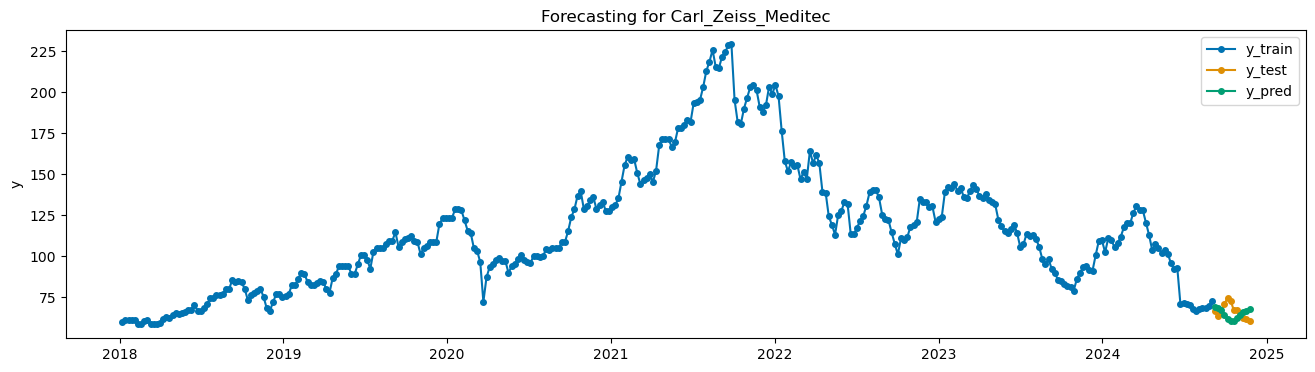


Processing company: Lam_Research_Corporation...


Best parameters for Lam_Research_Corporation: {'changepoint_prior_scale': 0.00117, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.005, 'weekly_seasonality': True, 'yearly_seasonality': False}
MAPE: 3.77
RMSE: 3.86


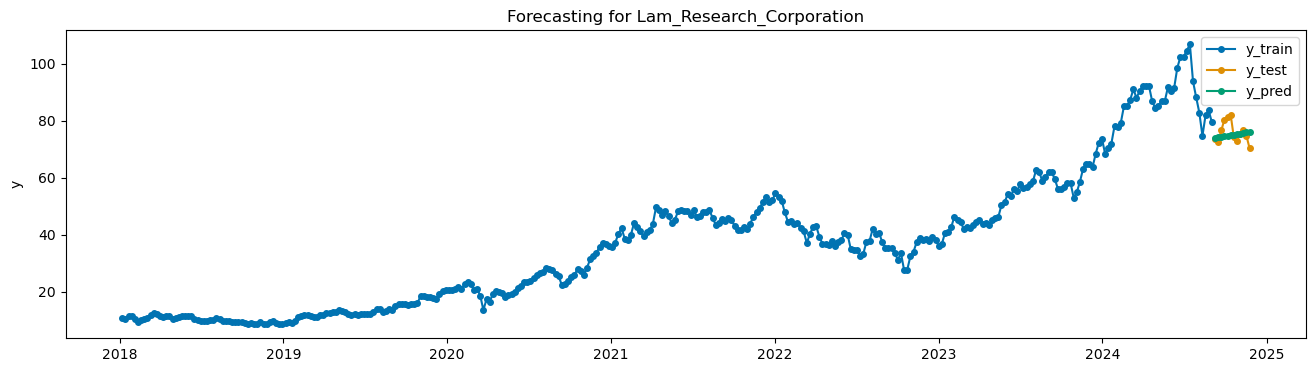


Processing company: Tokyo_Electron_Limited...


Best parameters for Tokyo_Electron_Limited: {'changepoint_prior_scale': 0.00067, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.02, 'weekly_seasonality': True, 'yearly_seasonality': False}
MAPE: 6.06
RMSE: 5.64


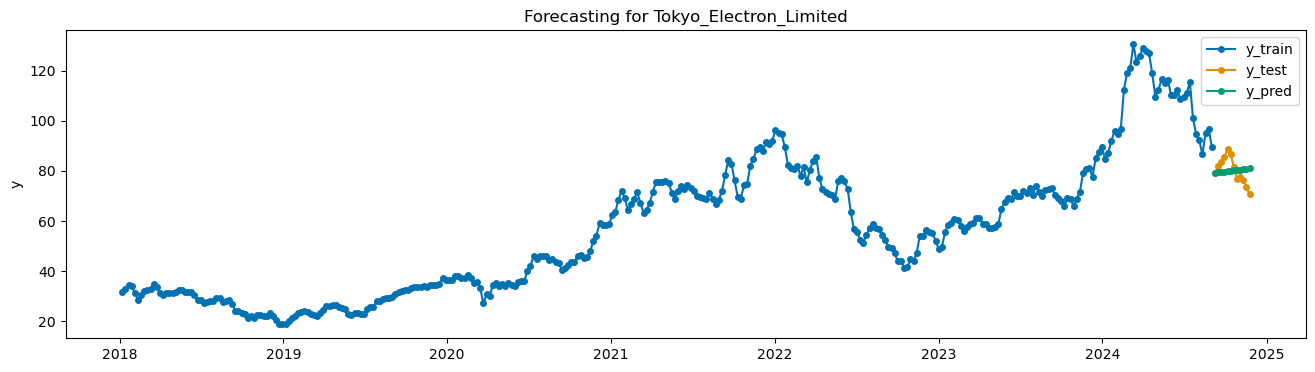

In [23]:
# Dictionary to store each Prophet model by company
prophet_models_train = {}

# Dictionary to store each Prophet model by company
prophet_models = {}

# Iterate over each company in company_params
for company, params in company_params.items():
    print(f"\nProcessing company: {company}...\n")

    # Define the parameter grid for the current company
    param_grid = {
        'changepoint_prior_scale': np.round(
            np.linspace(params['changepoint_prior_scale'] / 2, params['changepoint_prior_scale'] * 2, 10), 5
        ),
        'seasonality_prior_scale': np.round(
            np.linspace(params['seasonality_prior_scale'] / 2, params['seasonality_prior_scale'] * 2, 10), 5
        ),
        'seasonality_mode': ['multiplicative'],
        'weekly_seasonality': [True, False],
        'yearly_seasonality': [True, False],
        'daily_seasonality': [True, False]
    }

    # Generate all parameter combinations using ParameterGrid
    param_combinations = list(ParameterGrid(param_grid))

    # Prepare training and test data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    test_data = test_dataframes[company][['Close']].copy()
    test_data.index = pd.to_datetime(test_data.index)

    # Initialize variables to track the best parameters
    best_mape = float('inf')
    best_rmse = float('inf')
    best_params = None

    # Iterate over all parameter combinations
    for combination in param_combinations:
        try:
            # Fit the Prophet model with the current parameter combination
            model = Prophet(
                changepoint_prior_scale=combination['changepoint_prior_scale'],
                seasonality_prior_scale=combination['seasonality_prior_scale'],
                seasonality_mode=combination['seasonality_mode'],
                weekly_seasonality=combination['weekly_seasonality'],
                yearly_seasonality=combination['yearly_seasonality'],
                daily_seasonality=combination['daily_seasonality']
            )
            model.fit(train_data_prophet)

            # Make predictions
            future = model.make_future_dataframe(periods=test_weeks, freq='W')
            forecast = model.predict(future)
            forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

            # Calculate MAPE and RMSE
            actuals = test_data['Close']
            predictions = forecast_filtered['Close']
            common_index = actuals.index.intersection(predictions.index)
            actuals = actuals.loc[common_index]
            predictions = predictions.loc[common_index]

            mape = mean_absolute_percentage_error(actuals, predictions) * 100
            rmse = root_mean_squared_error(actuals, predictions)

            # Update the best parameters if the current MAPE is lower
            if mape < best_mape:
                best_mape = mape
                best_rmse = rmse
                best_params = combination
        except Exception as e:
            print(f"Error with parameters: {combination}: {e}")

    # Print the best parameters, MAPE, and RMSE for the current company
    print(f"\nBest parameters for {company}: {best_params}")
    print(f"MAPE: {best_mape:.2f}")
    print(f"RMSE: {best_rmse:.2f}")

    # Plot the forecast results for the best parameters
    model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        weekly_seasonality=best_params['weekly_seasonality'],
        yearly_seasonality=best_params['yearly_seasonality'],
        daily_seasonality=best_params['daily_seasonality']
    )
    model.fit(train_data_prophet)
    
    # Store the model in the dictionary with the company name as key just for training data
    prophet_models_train[company] = model

    future = model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    plot_series(
        train_data_prophet.set_index("ds")['y'][-500:],  # Last 500 points of training data
        test_data['Close'],
        forecast_filtered['Close'],
        labels=["y_train", "y_test", "y_pred"]
    )
    plt.title(f"Forecasting for {company}")
    plt.show()

    # Fit the Prophet model with all data (train and test) for final storage
    prophet_model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        weekly_seasonality=best_params['weekly_seasonality'],
        yearly_seasonality=best_params['yearly_seasonality'],
        daily_seasonality=best_params['daily_seasonality']
    )

    # Prepare combined data for final model training
    test_data = pd.DataFrame(actuals).rename(columns={'Close': 'y'}).reset_index(names="ds")
    all_data = pd.concat([train_data_prophet, test_data])
    prophet_model.fit(all_data)

    # Store the model in the dictionary with the company name as key
    prophet_models[company] = prophet_model

#### 2.5.6.4 Save the best prophet models of ASML's suppliers

In [24]:
# Iterate over each company in prophet_models
for company in company_tickers.values():
    # Define the output path for the current company's model
    output_model_path = f'models/prophet_asml_supplier_{company.replace(" ", "_")}.pkl'

    # Save the current company's Prophet model
    joblib.dump(prophet_models[company], output_model_path)
    print(f'Prophet model for {company} saved at {output_model_path}')

Prophet model for Carl_Zeiss_Meditec saved at models/prophet_asml_supplier_Carl_Zeiss_Meditec.pkl
Prophet model for Lam_Research_Corporation saved at models/prophet_asml_supplier_Lam_Research_Corporation.pkl
Prophet model for Tokyo_Electron_Limited saved at models/prophet_asml_supplier_Tokyo_Electron_Limited.pkl


#### 2.5.6.5 Save the best prophet models of ASML's suppliers with train_data

In [25]:
# Iterate over each company in prophet_models
for company in company_tickers.values():
    # Define the output path for the current company's model
    output_model_path = f'models/prophet_asml_supplier_train_{company.replace(" ", "_")}.pkl'

    # Save the current company's Prophet model
    joblib.dump(prophet_models_train[company], output_model_path)
    print(f'Prophet model for {company} saved at {output_model_path}')

Prophet model for Carl_Zeiss_Meditec saved at models/prophet_asml_supplier_train_Carl_Zeiss_Meditec.pkl
Prophet model for Lam_Research_Corporation saved at models/prophet_asml_supplier_train_Lam_Research_Corporation.pkl
Prophet model for Tokyo_Electron_Limited saved at models/prophet_asml_supplier_train_Tokyo_Electron_Limited.pkl


# 3. Export the data

In [26]:
# Export the weekly_data_suppliers to a CSV file
weekly_data_suppliers.to_csv(output_data, index=True, sep=';')